In [2]:
import numpy as np

class orbitElements:

    # t0 is in days, M is in kg
    # Takes in two options:
    # ONE:
    # elements = (a, ecc, inc, RAAN, omega, M0)
    # a = Semi-major axis (m)
    # ecc = Eccentricity
    # inc = Inclination (rad)
    # RAAN = Right ascention of the ascending node (rad) also called longitude of ascending node
    # omega = Argument of periapsis (rad)
    # M0 = Mean anomaly at t = 0 (radians)
    # TWO:
    # Position vector (m)
    # Velocity vector (m/s)

    # Transcribed from Matlab code written by mentor Sam Califf
    def __init__(self, elements = None, posVec = None, velVec = None, t0 = 0, mass = None):
        # Standard gravitational parameter
        if not mass is None:
            # mass_Earth = 5.9722*10**24
            self.mu = 6.67428e-11*mass
        else:
            self.mu = 3.986004418e14 
        self.t0 = t0
        if not elements is None:
            self.a, self.ecc, self.inc, self.RAAN, self.omega, self.M0 = elements
        else:
            self.a, self.ecc, self.inc, self.RAAN, self.omega, self.M0 = self.get_orbital_elements(posVec, velVec)
            print(self.get_orbital_elements(posVec, velVec))



    def get_orbital_elements(self, posVec, velVec, dt = 0):

        def magnitude(vector):
            sum = 0.0
            for element in vector:
                sum += element**2
            return sum**0.5

        posVec = np.array(posVec, dtype = float)
        velVec = np.array(velVec, dtype = float)
        
        r = magnitude(posVec) # m
        V = np.dot(velVec, velVec) # m^2/s^2

        # Semi-major axis
        # print(f"r: {r}")
        # print(f"V: {V}")
        alpha = 2/r - V/self.mu
        a = 1/alpha

        # print(f"a: {a}")

        # Angular momentum
        h_vec = np.cross(posVec, velVec)
        # print(f"h_vec: {h_vec}")
        h_unit = h_vec/magnitude(h_vec)

        # print(f"h_unit: {h_unit}")

        # Eccentricity
        ecc_vec = np.cross(velVec, h_vec)/self.mu - posVec/r
        ecc = magnitude(ecc_vec)

        # print(f"ecc: {ecc}")

        # Perifocal frame unit vectors
        ihat_e = ecc_vec/ecc
        ihat_h = h_unit
        ihat_p = np.cross(ihat_h, ihat_e)

        # Transformation matrix from perifcoal frame to inertial frame
        PN = np.transpose(np.concatenate((np.reshape(ihat_e, (-1, 1)), np.reshape(ihat_p, (-1, 1)), np.reshape(ihat_h, (-1, 1))), axis = 1))
        # print(f"PN: {PN}")

        # Back out RAAN, i, omega
        RAAN = np.arctan2(PN[2, 0], -1*PN[2, 1])
        inc = np.arccos(PN[2, 2])
        omega = np.arctan2(PN[0, 2], PN[1, 2])

        # Argument of perigee
        ihat_r = posVec/r
        f = np.arctan2(np.dot(np.cross(ihat_e, ihat_r), ihat_h), np.dot(ihat_e, ihat_r))

        

        # print(f"RAAN: {RAAN}")
        # print(f"inc: {inc}")
        # print(f"omega: {omega}")

        # print(f"f: {f}")

        if a > 0: # Elliptical
            # Mean motion
            n = np.sqrt(self.mu/a**3)

            # Eccentric anomaly
            E = 2*np.arctan(np.sqrt((1-ecc)/(1+ecc))*np.tan(f/2))

            # Mean anomaly:
            M = E - ecc*np.sin(E)

            # Propogate mean anomaly
            M0 = M + n*dt
        
        else: # Hyperbolic
            # Mean motion
            n = np.sqrt(self.mu/(-a**3))

            # Hyperbolic anomaly
            # Possible quadrant ambiguity
            H = 2*np.arctanh(np.sqrt((ecc-1)/(ecc+1))*np.tan(f/2))

            # Mean anomaly
            N = ecc*np.sinh(H) - H

            # Propogate mean anomaly
            M0 = N + n*dt

        # print(f"M0: {M0}")

        return (a, ecc, inc, RAAN, omega, M0)
    
    
    def calculateOrbit(self, dt, includeDrift = True):
        J2 = 1.08262668e-3
        # Earth radius (m)
        Re = 6378.138e3

        if self.a > 0:
            n = np.sqrt(self.mu/self.a**3)
        else:
            n = np.sqrt(self.mu/(-self.a**3))
        
        if includeDrift:
            dRAAN_dt = -1.5*n*J2*(Re/self.a)**2*np.cos(self.inc)*(1-self.ecc**2)**-2
            dOmega_dt = 0.75*n*J2*(Re/self.a)**2*(4-5*(np.sin(self.inc)**2))*(1-self.ecc**2)**-2
        else:
            dRAAN_dt = 0
            dOmega_dt = 0
        
        RAAN_adj = self.RAAN+dRAAN_dt*dt
        omega_adj = self.omega+dOmega_dt*dt
        

        
        # Semilatus rectum
        p = self.a*(1-self.ecc**2)

        # Mean anomaly is different for elliptical and hyperbolic orbits
        if self.a > 0:
            # Compute mean motion

            # Propoagate mean anomaly
            M = self.M0 + n * dt

            # Use Newton-Raphson method to solve for E
            E = M
            err_tol = 1e-10
            err = M - (E - self.ecc*np.sin(E))

            while abs(err) > err_tol:
                df = -(1-self.ecc*np.cos(E))
                E = E - err/df
                err = M - (E - self.ecc*np.sin(E))
            
            # f/2 and E/2 are always between 0-180, so quadrants aren't a problem
            f = 2*np.arctan(np.sqrt((1+self.ecc)/(1-self.ecc))*np.tan(E/2))
            theta = omega_adj+f

            r = p/(1+self.ecc*np.cos(f))
        
        else:
            N = self.M0 + n*dt

            err_tol = 1e-10
            H = N
            err = N - (self.ecc*np.sinh(H)-H)

            while abs(err) > err_tol:
                df = -(self.ecc*np.cosh(H) - 1)
                H = H - err/df
                err = N - (self.ecc*np.sinh(H) - H)
            
            # We don't need true anomaly, but we'll calculate it anyways :)
            f = 2*np.arctan(np.sqrt((self.ecc+1)/(self.ecc-1))*np.tanh(H/2))
            theta = omega_adj + f

            # Radius
            r = self.a*(1-self.ecc*np.cosh(H))

        """print(f"theta = {theta}")
        print(f"r = {r}")
        print(f"E = {E}")"""
        
        # Position vector in inertial frame
        x_eci = r*np.array([np.cos(RAAN_adj)*np.cos(theta)-np.sin(RAAN_adj)*np.sin(theta)*np.cos(self.inc),
                        np.sin(RAAN_adj)*np.cos(theta)+np.cos(RAAN_adj)*np.sin(theta)*np.cos(self.inc),
                        np.sin(theta)*np.sin(self.inc)])

        # Velocity in the inertial frame
        h = np.sqrt(p*self.mu)
        v_eci = -self.mu/h*np.array([np.cos(RAAN_adj)*(np.sin(theta)+self.ecc*np.sin(omega_adj)) + np.sin(RAAN_adj)*(np.cos(theta)+self.ecc*np.cos(omega_adj))*np.cos(self.inc),
                        np.sin(RAAN_adj)*(np.sin(theta)+self.ecc*np.sin(omega_adj)) - np.cos(RAAN_adj)*(np.cos(theta)+self.ecc*np.cos(omega_adj))*np.cos(self.inc),
                        -(np.cos(theta)+self.ecc*np.cos(omega_adj))*np.sin(self.inc)])

        return (x_eci, v_eci)
    
    # Returns propogated elements while including drift
    def getPropogatedElements(self, dt):
        J2 = 1.08262668e-3
        # Earth radius (m)
        Re = 6378.138e3

        if self.a > 0:
            n = np.sqrt(self.mu/self.a**3)
        else:
            n = np.sqrt(self.mu/(-self.a**3))
        
        dRAAN_dt = -1.5*n*J2*(Re/self.a)**2*np.cos(self.inc)*(1-self.ecc**2)**-2
        dOmega_dt = 0.75*n*J2*(Re/self.a)**2*(4-5*(np.sin(self.inc)**2))*(1-self.ecc**2)**-2
        
        RAAN_adj = self.RAAN+dRAAN_dt*dt
        omega_adj = self.omega+dOmega_dt*dt

        return (self.a, self.ecc, self.inc, RAAN_adj, omega_adj, self.M0)



            




(5956308.947288432, 0.15474198213495305, 0.7853981633974484, 0.0, -3.141592653589793, 3.141592653589793)
(array([6878000.,       0.,       0.]), array([1.56914169e-13, 4.94900000e+03, 4.94900000e+03]))


[Text(0.5, 0, 'GSE x (m)'),
 Text(0.5, 0.5, 'GSE y (m)'),
 Text(0.5, 0, 'GSE z (m)')]

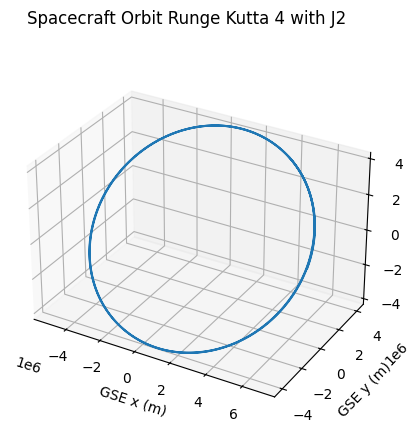

In [7]:
import matplotlib.pyplot as plt
#theOrbit = orbitElements(posVec = [6878000, 0, 0], velVec = [0, 4949, 4949])
theOrbit = orbitElements(posVec = [6878000, 0, 0], velVec = [0, 4949, 4949])
print(theOrbit.calculateOrbit(0))
segmentCount = 10000
dt = 1
curve = np.zeros((segmentCount, 3))
for i in range(0, segmentCount):
    curve[i, 0], curve[i, 1], curve[i, 2] = theOrbit.calculateOrbit(dt*i)[0]


fig = plt.figure()
fig.suptitle('Spacecraft Orbit Runge Kutta 4 with J2')
axis = fig.add_subplot(projection='3d')
axis.plot(curve[:, 0], curve[:, 1], curve[:, 2])
axis.set_aspect('equal')
axis.set(xlabel = "GSE x (m)", ylabel = "GSE y (m)", zlabel = "GSE z (m)")
#print(curve)